In [1]:
from model import GeoCLIP
from model import ImageEncoder
from model import LocationEncoder
from train import train
from train import dataloader
import os
from torch import nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def haversine_distance(lon1, lat1, lon2, lat2):
    '''Find distance between locations in meters'''

    R = 6371000 # radius of Earth in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = (np.sin(delta_phi / 2))**2 + np.cos(phi1) * np.cos(phi2) * (np.sin(delta_lambda / 2))**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [3]:
df = pd.read_csv("/workspace/mappilary_street_level/train_val/amsterdam/query/raw.csv")
df_no_panorama = df[~df["pano"]]

In [4]:
df_distance = df_no_panorama[["lat", "lon"]].values
distances_map = dict()
min_distance = 100
start_coords = df_distance[0]
for i in range(1, len(df_distance)):
    dist = haversine_distance(start_coords[1], start_coords[0], df_distance[i][1], df_distance[i][0])
    if dist >= min_distance:
        start_coords = df_distance[i]
        distances_map[i] = dist

In [5]:
selected_images_no_jpg = df_no_panorama.iloc[list(distances_map.keys())].key.values
selected_images = [f"{img}.jpg" for img in selected_images_no_jpg]
gps_coords = list(distances_map.keys())

In [6]:
# Filter all rows where key is in selected_images_no_jpg
df_keys = df_no_panorama[df_no_panorama["key"].isin(selected_images_no_jpg)][["lon", "lat"]]
np_keys = df_keys.reset_index(drop=True, inplace=False).values

In [7]:
df_no_panorama[["lat", "lon"]].describe()

,lat,lon
count,2023.000000,2023.000000
mean,52.342687,4.813145
std,0.044845,0.034215
min,52.287261,4.721708
25%,52.306853,4.794043
50%,52.331757,4.817008
75%,52.371424,4.843834
max,52.457840,4.862012


In [8]:
df_keys.describe()

,lon,lat
count,369.000000,369.000000
mean,4.814902,52.344845
std,0.032596,0.044720
min,4.722466,52.287374
25%,4.793342,52.310128
50%,4.818210,52.333257
75%,4.844248,52.373264
max,4.861579,52.457840


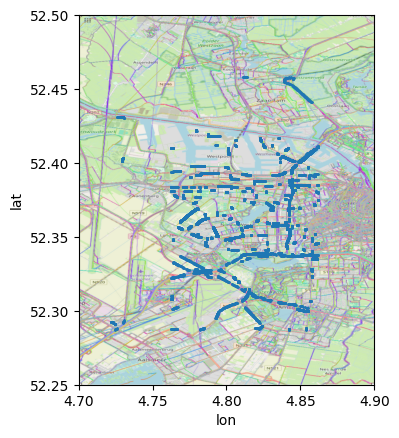

In [9]:
df[['lat', 'lon']].plot(kind='scatter', x='lon', y='lat', s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

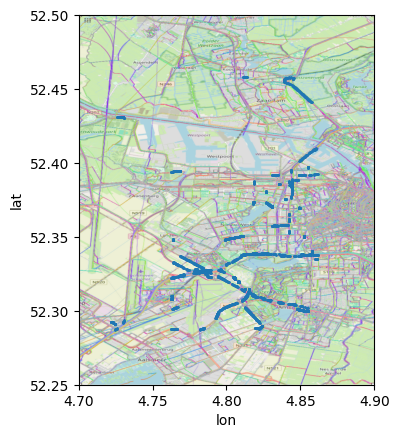

In [10]:
df_no_panorama[['lat', 'lon']].plot(kind='scatter', x='lon', y='lat', s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

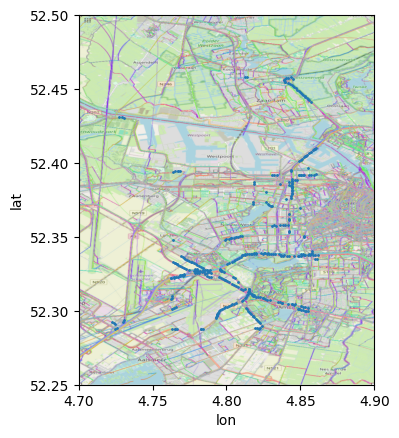

In [11]:
df_keys.plot.scatter(x="lon", y="lat", s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

In [12]:
torch.empty((4,) + (256, 256), dtype=torch.float32).shape

torch.Size([4, 256, 256])

In [13]:
import pdb
class AmsterdamData(torch.utils.data.Dataset):
    def __init__(self, root: str, selected_images: np.ndarray, gps: np.ndarray, transform_aug=None, transform=None):
        self.root = root
        self.transform = transform
        self.transform_aug = transform_aug
        self.images = selected_images
        self.coordinates = gps
        self.n_aug = 2

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     # Send back image and 3 augmented images
    #     gps = torch.tensor(self.coordinates[idx], dtype=torch.float32)
    #     img = Image.open(os.path.join(self.root, self.images[idx]))
    #     if self.transform:
    #         img = self.transform(img)
    #     # Preallocate tensor with size of 4 images
    #     # add the augmented images 
    #     # to the preallocated tensor using slices

    def __getitem__(self, idx):
        gps = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        img = Image.open(os.path.join(self.root, self.images[idx]))
        # if self.transform_aug:
        img_1 = self.transform_aug(img)
        augmented_images = torch.empty((self.n_aug,) + img_1.shape, dtype=torch.float32)
        augmented_images[0] = img_1
        #pdb.set_trace()
        for i in range(1, self.n_aug):
            print(i)
            augmented_images[i] = self.transform_aug(img)

        return augmented_images, gps

In [14]:
class ContrastiveQueueLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.1):
        super(ContrastiveQueueLoss, self).__init__()
        self.temperature = temperature
        self.batch_size = batch_size

    def contrastive_loss(self, v_i: torch.Tensor, l_i: torch.Tensor, q, tau):
        numerator = torch.exp(v_i @ l_i.T / tau)
        # Summation trick to allow us to divide by tau
        # Break out tau and exponential out of the sum, sum only the features

        denominator = torch.sum(torch.exp(torch.matmul(v_i, l_i.T) / tau), dim=1) \
            + torch.sum(torch.exp(torch.matmul(v_i, q.T) / tau), dim=1)
        # Do we need len(q) number of v_i here?
        return torch.log(numerator / denominator)

    def forward(self, V, L, queue):
        # For every augmentation, calculate the loss and sum them up
        loss = 0
        for j in range(V.shape[0]):
            loss += self.contrastive_loss(V[j], L[j], queue, self.temperature)
        return -loss

In [15]:
from typing import Tuple, Union
class MemoryBankModule(nn.Module):
    """
    Implementation from https://github.com/lightly-ai/lightly/blob/master/lightly/loss/ntx_ent_loss.py
    """
    def __init__(
            self,
            size: int = 4096,
        ):
            super().__init__()
            self.size = size
            self.bank: torch.Tensor
            self.register_buffer(
                "bank",
                tensor=torch.empty(size=size, dtype=torch.float),
                persistent=False,
            )
            self.bank_ptr: torch.Tensor
            self.register_buffer(
                "bank_ptr",
                tensor=torch.empty(1, dtype=torch.long),
                persistent=False,
            )

    @torch.no_grad()
    def _init_memory_bank(self, size: int) -> None:
        """Initialize the memory bank.

        Args:
            size:
                Size of the memory bank as (num_features, dim) tuple.

        """
        self.bank = torch.randn(size).type_as(self.bank)
        self.bank = torch.nn.functional.normalize(self.bank, dim=-1)
        self.bank_ptr = torch.zeros(1).type_as(self.bank_ptr)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, batch: torch.Tensor) -> None:
        """Dequeue the oldest batch and add the latest one

        Args:
            batch:
                The latest batch of keys to add to the memory bank.

        """

        batch_size = batch.shape[0]
        ptr = int(self.bank_ptr)
        if ptr + batch_size >= self.size[0]:
            self.bank[ptr:] = batch[: self.size[0] - ptr].detach()
            self.bank_ptr.zero_()
        else:
            self.bank[ptr : ptr + batch_size] = batch.detach()
            self.bank_ptr[0] = ptr + batch_size

    def forward(
        self,
        output: torch.Tensor,
        update: bool = False,
    ) -> Tuple[torch.Tensor, Union[torch.Tensor, None]]:
        """Query memory bank for additional negative samples

        Args:
            output:
                The output of the model.
            update:
                If True, the memory bank will be updated with the current output.

        Returns:
            The output if the memory bank is of size 0, otherwise the output
            and the entries from the memory bank. Entries from the memory bank have
            shape (dim, num_features) if feature_dim_first is True and
            (num_features, dim) otherwise.
        """

        # no memory bank, return the output
        if self.size[0] == 0:
            return output, None

        # Initialize the memory bank if it is not already done.
        if self.bank.ndim == 1:
            dim = output.shape[1:]
            self._init_memory_bank(size=(*self.size, *dim))

        # query and update memory bank
        bank = self.bank.clone().detach()
        if self.feature_dim_first:
            # swap bank size and feature dimension for backwards compatibility
            bank = bank.transpose(0, -1)

        # only update memory bank if we later do backward pass (gradient)
        if update:
            self._dequeue_and_enqueue(output)

        return output, bank

class NTXentLoss(MemoryBankModule):
    """        
    Implementation from https://github.com/lightly-ai/lightly/blob/master/lightly/loss/ntx_ent_loss.py
    """

    def __init__(self, temp: float = 0.01, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.temperature = temp

    def forward(self, img_emb: Tuple[torch.Tensor, torch.Tensor], gps_emb: torch.Tensor, gps_emb_q: torch.Tensor):
        # Forward pass for MOCO inspired setup 
        # with a queue for negative samples
        # x0 and x1 are the augmented images
        # gps_feat_q is the queue of negative samples
        x0, x1 = img_emb

        device = x0.device
        # Normalize the features
        x0 = F.normalize(x0, dim=1)
        x1 = F.normalize(x1, dim=1)

        # This gets the negative samples from the queue
        #x1, negatives = super(NTXentLoss, self).forward(x1, update=x0.required_grad)

        c_0 = x0.dot(gps_emb)
        c_1 = x1.dot(gps_emb)
        sim_pos = c_0.dot(c_1)
        sim_neg = c_0.dot(gps_emb_q) # negatives

        logits = torch.cat([sim_pos, sim_neg], dim=1) / self.temperature
        # Zeros implies that the first index is the correct class for the image (the positive sample)
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=device)

        loss = F.cross_entropy(logits, labels)
        return loss

        

In [16]:
def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)

class SimCLRLoss(nn.Module):

    def __init__(self, batch_size: int, temperature: int):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()


    def calc_similarity_batch(self, a: torch.Tensor, b: torch.Tensor):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        
    def forward(self, proj_1: torch.Tensor, proj_2: torch.Tensor):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        # Postive similarities are on the off-diagonals
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        # Mask out the main diagonal and calculate the softmax
        denominator = (self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

In [17]:
class BestModel(nn.Module):
    def __init__(self, image_encoder, location_encoder):
        super(BestModel, self).__init__()
        self.Geoclip = GeoCLIP()
        for param in self.Geoclip.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(512, 512)

    def forward(self, image, location):
        x = self.Geoclip(image, location)
        return self.fc(x)



In [18]:
def img_augment_transform():
    train_transform_list = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return train_transform_list

def img_transform():
    train_transform_list = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return train_transform_list

In [19]:
EPOCHS = 2
BATCH_SIZE = 2

In [20]:
geo_clip = GeoCLIP(batch_size=BATCH_SIZE, device="cuda:0")
geo_clip.to("cuda:0")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


GeoCLIP(
  (image_encoder): ImageEncoder(
    (CLIP): CLIPModel(
      (text_model): CLIPTextTransformer(
        (embeddings): CLIPTextEmbeddings(
          (token_embedding): Embedding(49408, 768)
          (position_embedding): Embedding(77, 768)
        )
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
            

In [21]:
optim = torch.optim.SGD(geo_clip.parameters(), lr=0.1)
criterion = ContrastiveQueueLoss(batch_size=BATCH_SIZE, temperature=0.1) #SimCLRLoss(BATCH_SIZE, 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
dataset = AmsterdamData(root="/workspace/mappilary_street_level/train_val/amsterdam/query/images",
                        selected_images=selected_images, gps=np_keys, transform=img_transform(),
                        transform_aug=img_augment_transform())
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
#geo_clip.save("model")

In [22]:
#geo_clip.predict("/workspace/geoclip/images/Kauai.png", 10)

In [23]:
data = iter(loader)

In [24]:
# inspect the data
images, gps = next(data)

1
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


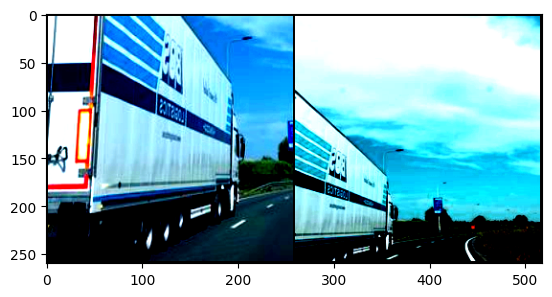

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


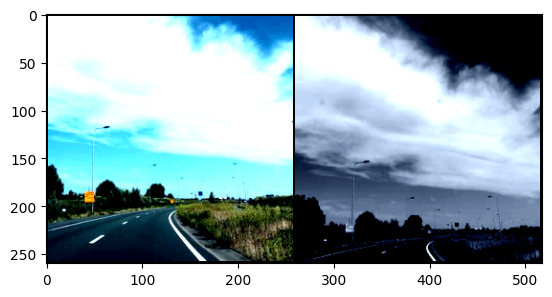

In [25]:
def imshow(img):
    img = img / 1.75 #+ 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(BATCH_SIZE):
    imshow(torchvision.utils.make_grid(images[i]))


In [26]:
train(loader, geo_clip, criterion, optim, scheduler, epoch=EPOCHS, batch_size=BATCH_SIZE, device="cuda:0")

Starting Epoch 2


  0%|          | 0/185 [00:00<?, ?it/s]

1
1


ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-2.1179039478302, 1.8905447721481323] which cannot be converted to uint8.

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")



config.json: 100%|██████████| 4.19k/4.19k [00:00<00:00, 21.0MB/s]
pytorch_model.bin: 100%|██████████| 605M/605M [01:20<00:00, 7.51MB/s] 
tokenizer_config.json: 100%|██████████| 568/568 [00:00<00:00, 3.62MB/s]
vocab.json: 100%|██████████| 862k/862k [00:00<00:00, 1.95MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.59MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:00<00:00, 3.42MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<00:00, 2.27MB/s]


In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
print(inputs["pixel_values"].shape)
#image_features = model.get_image_features(**inputs)

torch.Size([1, 3, 224, 224])
